Trey Tuscai

Spring 2023

CS 251/2: Data Analysis and Visualization

Project 6: Supervised learning

In [9]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

plt.style.use(['seaborn-v0_8-colorblind', 'seaborn-v0_8-darkgrid'])
plt.rcParams.update({'font.size': 20})

np.set_printoptions(suppress=True, precision=5)

# Automatically reload external modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Task 3: Preprocess full spam email dataset 

Before you build a Naive Bayes spam email classifier, run the full spam email dataset through your preprocessing code.

Download and extract the full **Enron** emails (*zip file should be ~29MB large*). You should see a base `enron` folder, with `spam` and `ham` subfolders when you extract the zip file (these are the 2 classes).

Run the test code below to check everything over.

### 3a) Preprocess dataset

In [10]:
import email_preprocessor as epp

#### Test `count_words` and `find_top_words`

In [11]:
word_freq, num_emails = epp.count_words()

In [12]:
print(f'You found {num_emails} emails in the datset. You should have found 32625.')

You found 32625 emails in the datset. You should have found 32625.


In [13]:
top_words, top_counts = epp.find_top_words(word_freq)
print(f"Your top 5 words are\n{top_words[:5]}\nand they should be\n['the', 'to', 'and', 'of', 'a']")
print(f"The associated counts are\n{top_counts[:5]}\nand they should be\n[277459, 203659, 148873, 139578, 111796]")

Your top 5 words are
['the', 'to', 'and', 'of', 'a']
and they should be
['the', 'to', 'and', 'of', 'a']
The associated counts are
[277459, 203659, 148873, 139578, 111796]
and they should be
[277459, 203659, 148873, 139578, 111796]


### 3b) Make train and test splits of the dataset

Here we divide the email features into a 80/20 train/test split (80% of data used to train the supervised learning model, 20% we withhold and use for testing / prediction).

In [14]:
features, y = epp.make_feature_vectors(top_words, num_emails)

In [15]:
np.random.seed(0)
x_train, y_train, inds_train, x_test, y_test, inds_test = epp.make_train_test_sets(features, y)

In [16]:
print('Shapes for train/test splits:')
print(f'Train {x_train.shape}, classes {y_train.shape}')
print(f'Test {x_test.shape}, classes {y_test.shape}')
print('\nThey should be:\nTrain (26100, 200), classes (26100,)\nTest (6525, 200), classes (6525,)')

Shapes for train/test splits:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)

They should be:
Train (26100, 200), classes (26100,)
Test (6525, 200), classes (6525,)


### 3c) Save data in binary format

It adds a lot of overhead to have to run through your raw email -> train/test feature split every time you wanted to work on your project! In this step, you will export the data in memory to disk in a binary format. That way, you can quickly load all the data back into memory (directly in ndarray format) whenever you want to work with it again. No need to parse from text files!

Running the following cell uses numpy's `save` function to make six files in `.npy` format (e.g. `email_train_x.npy`, `email_train_y.npy`, `email_train_inds.npy`, `email_test_x.npy`, `email_test_y.npy`, `email_test_inds.npy`).

In [17]:
np.save('data/email_train_x.npy', x_train)
np.save('data/email_train_y.npy', y_train)
np.save('data/email_train_inds.npy', inds_train)
np.save('data/email_test_x.npy', x_test)
np.save('data/email_test_y.npy', y_test)
np.save('data/email_test_inds.npy', inds_test)

## Task 4: Naive Bayes Classifier

After finishing your email preprocessing pipeline, implement the one other supervised learning algorithm we we will use to classify email, **Naive Bayes**.

### 4a) Implement Naive Bayes

In `naive_bayes.py`, implement the following methods:
- Constructor
- get methods
- `train(data, y)`: Train the Naive Bayes classifier so that it records the "statistics" of the training set: class priors (i.e. how likely an email is in the training set to be spam or ham?) and the class likelihoods (the probability of a word appearing in each class — spam or ham).
- `predict(data)`: Combine the class likelihoods and priors to compute the posterior distribution. The predicted class for a test sample is the class that yields the highest posterior probability.
- `accuracy(y, y_pred)`: The usual definition :)


#### Bayes rule ingredients: Priors and likelihood (`train`)

To compute class predictions (probability that a test example belong to either spam or ham classes), we need to evaluate **Bayes Rule**. This means computing the priors and likelihoods based on the training data.

**Prior:** $$P_c = \frac{N_c}{N}$$ where $P_c$ is the prior for class $c$ (spam or ham), $N_c$ is the number of training samples that belong to class $c$ and $N$ is the total number of training samples.

**Likelihood:** $$L_{c,w} = \frac{N_{c,w} + 1}{N_{c} + M}$$ where
- $L_{c,w}$ is the likelihood that word $w$ belongs to class $c$ (*i.e. what we are solving for*)
- $N_{c,w}$ is the total count of **word $w$** in emails that are only in class $c$ (*either spam or ham*)
- $N_{c}$ is the total number of **all words** that appear in emails of the class $c$ (*total number of words in all spam emails or total number of words in all ham emails*)
- $M$ is the number of features (*number of top words*).

#### Bayes rule ingredients: Posterior (`predict`)

To make predictions, we now combine the prior and likelihood to get the posterior:

**Log Posterior:** $$Log(\text{Post}_{i, c}) = Log(P_c) + \sum_{j \in J_i}x_{i,j}Log(L_{c,j})$$

 where
- $\text{Post}_{i,c}$ is the posterior for class $c$ for test sample $i$(*i.e. evidence that email $i$ is spam or ham*). We solve for its logarithm.
- $Log(P_c)$ is the logarithm of the prior for class $c$.
- $x_{i,j}$ is the number of times the jth word appears in the ith email.
- $Log(L_{c,j})$: is the log-likelihood of the jth word in class $c$.

In [18]:
from naive_bayes import NaiveBayes

#### Test `train`

###### Class priors and likelihoods

The following test should be used only if storing the class priors and likelihoods directly.

In [ ]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.randint(low=0, high=20, size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your class priors are: {nbc.get_priors()}\nand should be          [0.28 0.22 0.32 0.18].')
print(f'Your class likelihoods shape is {nbc.get_likelihoods().shape} and should be (4, 6).')
print(f'Your likelihoods are:\n{nbc.get_likelihoods()}')

print(f'and should be')
print('''[[0.15997 0.15091 0.2079  0.19106 0.14184 0.14832]
 [0.11859 0.16821 0.17914 0.16905 0.18082 0.18419]
 [0.16884 0.17318 0.14495 0.14332 0.18784 0.18187]
 [0.16126 0.17011 0.15831 0.13963 0.18977 0.18092]]''')

###### Log of class priors and likelihoods

This test should be used only if storing the log of the class priors and likelihoods.

In [20]:
num_test_classes = 4
np.random.seed(0)
data_test = np.random.randint(low=0, high=20, size=(100, 6))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_test, y_test)

print(f'Your log class priors are: {nbc.get_priors()}\nand should be              [-1.27297 -1.51413 -1.13943 -1.7148 ].')
print(f'Your log class likelihoods shape is {nbc.get_likelihoods().shape} and should be (4, 6).')
print(f'Your log likelihoods are:\n{nbc.get_likelihoods()}')


print(f'and should be')
print('''[[-1.83274 -1.89109 -1.57069 -1.65516 -1.95306 -1.90841]
 [-2.13211 -1.78255 -1.71958 -1.77756 -1.71023 -1.6918 ]
 [-1.77881 -1.75342 -1.93136 -1.94266 -1.67217 -1.70448]
 [-1.82475 -1.77132 -1.84321 -1.96879 -1.66192 -1.70968]]''')

Your log class priors are: [-1.27297 -1.51413 -1.13943 -1.7148 ]
and should be              [-1.27297 -1.51413 -1.13943 -1.7148 ].
Your log class likelihoods shape is (4, 6) and should be (4, 6).
Your log likelihoods are:
[[-1.83274 -1.89109 -1.57069 -1.65516 -1.95306 -1.90841]
 [-2.13211 -1.78255 -1.71958 -1.77756 -1.71023 -1.6918 ]
 [-1.77881 -1.75342 -1.93136 -1.94266 -1.67217 -1.70448]
 [-1.82475 -1.77132 -1.84321 -1.96879 -1.66192 -1.70968]]
and should be
[[-1.83274 -1.89109 -1.57069 -1.65516 -1.95306 -1.90841]
 [-2.13211 -1.78255 -1.71958 -1.77756 -1.71023 -1.6918 ]
 [-1.77881 -1.75342 -1.93136 -1.94266 -1.67217 -1.70448]
 [-1.82475 -1.77132 -1.84321 -1.96879 -1.66192 -1.70968]]


#### Test `predict`

In [21]:
num_test_classes = 4
np.random.seed(0)
data_train = np.random.randint(low=0, high=num_test_classes, size=(100, 10))
data_test = np.random.randint(low=0, high=num_test_classes, size=(15, 10))
y_test = np.random.randint(low=0, high=num_test_classes, size=(100,))

nbc = NaiveBayes(num_classes=num_test_classes)
nbc.train(data_train, y_test)
test_y_pred = nbc.predict(data_test)

print(f'Your predicted classes are\n{test_y_pred}\nand should be\n[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]')

Your predicted classes are
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]
and should be
[3 0 3 1 0 1 1 3 0 3 0 2 0 2 1]


### 4b) Spam filtering

Let's start classifying spam email using the Naive Bayes classifier. The following code uses `np.load` to load in the train/test split that you created last week.
- Use your Naive Bayes classifier on the Enron email dataset!

**Question 7:** Print out the accuracy that you get on the test set with Naive Bayes. It should be roughly 89%.

In [22]:
import email_preprocessor as ep

In [23]:
x_train = np.load('data/email_train_x.npy')
y_train = np.load('data/email_train_y.npy')
inds_train = np.load('data/email_train_inds.npy')
x_test = np.load('data/email_test_x.npy')
y_test = np.load('data/email_test_y.npy')
inds_test = np.load('data/email_test_inds.npy')

In [24]:
nbc = NaiveBayes(num_classes=2)
nbc.train(x_train, y_train)
test_y_pred = nbc.predict(x_test)
test_accuracy = nbc.accuracy(y_test, test_y_pred)
print(test_accuracy)

0.8924137931034483


### 4c) Confusion matrix

To get a better sense of the errors that the Naive Bayes classifer makes, you will create a confusion matrix. 

- Implement `confusion_matrix` in `naive_bayes.py`.
- Print out a confusion matrix of the spam classification results.

**Debugging guidelines**:
1. The sum of all numbers in your 2x2 confusion matrix should equal the number of test samples (6525).
2. The sum of your spam row should equal the number of spam samples in the test set (3193)
3. The sum of your ham row should equal the number of spam samples in the test set (3332)

In [25]:
conf_mat = nbc.confusion_matrix(y_test, test_y_pred)
print(conf_mat)
print("Sum of all: ", np.sum(conf_mat))
print("Sum of spam: ", np.sum(conf_mat[1]))
print("Sum of ham: ", np.sum(conf_mat[0]))


[[2780.  552.]
 [ 150. 3043.]]
Sum of all:  6525.0
Sum of spam:  3193.0
Sum of ham:  3332.0


**Question 8:** Interpret the confusion matrix, using the convention that positive detection means spam (*e.g. a false positive means classifying a ham email as spam*). What types of errors are made more frequently by the classifier? What does this mean (*i.e. X (spam/ham) is more likely to be classified than Y (spam/ham) than the other way around*)?

**Reminder:** Look back and make sure you are clear on which class indices correspond to spam/ham.

**Answer 8:**
Looking at the confusion matrix, we can see that the classifier makes more errors in classifying ham emails as spam than in classifying spam emails as ham. Specifically, out of the 3332 ham emails in the test set, 552 were misclassified as spam, while out of the 3193 spam emails in the test set, 150 were misclassified as ham.

## Task 5: Comparison with KNN


- Run a similar analysis to what you did with Naive Bayes above. When computing accuracy on the test set, you may want to reduce the size of the test set (e.g. to the first 500 emails in the test set).
- Copy-paste your `confusion_matrix` method into `knn.py` so that you can run the same analysis on a KNN classifier.

In [26]:
from knn import KNN

In [29]:
classifier = KNN(num_classes=2)
classifier.train(x_train, y_train)
test_y_pred = classifier.predict(x_test, 3)
conf_mat = classifier.confusion_matrix(y_test, test_y_pred)
print(conf_mat)
print("Sum of all: ", np.sum(conf_mat))
print("Sum of spam: ", np.sum(conf_mat[1]))
print("Sum of ham: ", np.sum(conf_mat[0]))
test_accuracy = classifier.accuracy(y_test, test_y_pred)
print(test_accuracy)

[[3031.  301.]
 [ 156. 3037.]]
Sum of all:  6525.0
Sum of spam:  3193.0
Sum of ham:  3332.0
0.9299616858237548


**Question 9:** What accuracy did you get on the test set (potentially reduced in size)?

**Question 10:** How does the confusion matrix compare to that obtained by Naive Bayes (*If you reduced the test set size, keep that in mind*)?

**Question 11:** Briefly describe at least one pro/con of KNN compared to Naive Bayes on this dataset.

**Question 12:** When potentially reducing the size of the test set here, why is it important that we shuffled our train and test set?

**Answer 9:** The unreduced test set with k=3 had about a 93% accuracy, which is better than naive bayes.

**Answer 10:** The confusion matrix still had the same problem (more frequently misclassifying ham as spam), but it had improved accuracy.

**Answer 11:** As a pro, KNN, in this case, is better at capturing the relationships between spam and ham. As a con, KNN can be computationally expensive and slow to run on large datasets because it needs to compute distances between each test sample and all training samples.

**Answer 12:** Shuffling the training and test sets before splitting them into smaller sets is important because it ensures that they contain a similar distribution of class labels.

## Extensions

## My Extensions
**For my first extension, I created a plot to show the accuracy for many different k values on the enron dataset. It took over 20 minutes, and I was able to go back and use this information to run the most accurate assessment. For my second extension, I investigated the misclassification errors by implementing the retrieve_emails method and countng the most common words. In general, they share many of the most common words, which could definitely lead to a missclassification.**

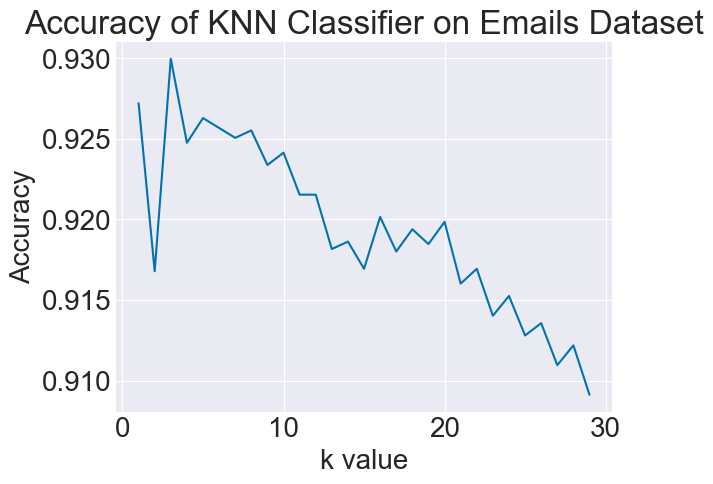

In [28]:
k_values = range(1, 30)
accuracy_values_emails = []
for k in k_values:
    classifier = KNN(num_classes=2)
    classifier.train(x_train, y_train)
    test_y_pred = classifier.predict(x_test, k)
    acc = classifier.accuracy(y=y_test, y_pred=test_y_pred)
    accuracy_values_emails.append(acc)
plt.plot(k_values, accuracy_values_emails)
plt.title('Accuracy of KNN Classifier on Emails Dataset')
plt.xlabel('k value')
plt.ylabel('Accuracy')
plt.show()

In [45]:
from collections import Counter
nbc = NaiveBayes(num_classes=2)
nbc.train(x_train, y_train)
test_y_pred = nbc.predict(x_test)
#ham but classified as spam
false_positives = np.where((y_test == 0) & (test_y_pred == 1))[0]
#spam but classified as ham
false_negatives = np.where((y_test == 1) & (test_y_pred == 0))[0]

fp_emails = ep.retrieve_emails(false_positives)
fn_emails = ep.retrieve_emails(false_negatives)

fp_text = ' '.join(fp_emails)
fp_words = fp_text.split()
fp_word_counts = Counter(fp_words)
print(fp_word_counts.most_common(20))

fn_text = ' '.join(fn_emails)
fn_words = fn_text.split()
fn_word_counts = Counter(fn_words)
print(fn_word_counts.most_common(20))



[('.', 42417), ('-', 33461), (',', 31808), ('the', 24288), ('to', 17383), ('/', 14464), (':', 13581), ('and', 12909), ('of', 12300), ('a', 9961), ('in', 8990), ("'", 6880), ('for', 6734), ('you', 6326), ('is', 5917), ('_', 5797), ('enron', 5580), ('this', 5071), ('on', 4887), ('that', 4718)]
[('.', 11106), ('-', 8547), (',', 7502), ('the', 6140), ('to', 4733), (':', 3623), ('and', 3603), ('/', 3517), ('of', 3318), ('a', 2441), ('in', 2258), ('you', 1962), ('for', 1934), ('is', 1645), ('this', 1604), ("'", 1491), ('>', 1467), ('_', 1438), ('on', 1352), ('i', 1330)]


### 0. Classify your own datasets

- Find datasets that you find interesting and run classification on them using your KNN algorithm (and if applicable, Naive Bayes). Analysis the performance of your classifer.

### 1. Better text preprocessing

- If you look at the top words extracted from the email dataset, many of them are common "stop words" (e.g. a, the, to, etc.) that do not carry much meaning when it comes to differentiating between spam vs. non-spam email. Improve your preprocessing pipeline by building your top words without stop words. Analyze performance differences.

### 2. Feature size

- Explore how the number of selected features for the email dataset influences accuracy and runtime performance.

### 3. Distance metrics
- Compare KNN performance with the $L^2$ and $L^1$ distance metrics

### 4. K-Fold Cross-Validation

- Research this technique and apply it to data and your KNN and/or Naive Bayes classifiers.

### 5. Email error analysis

- Dive deeper into the properties of the emails that were misclassified (FP and/or FN) by Naive Bayes or KNN. What is their word composition? How many words were skipped because they were not in the training set? What could plausibly account for the misclassifications?

### 6. Investigate the misclassification errors

Numbers are nice, but they may not the best for developing your intuition. Sometimes, you want to see what an misclassification *actually looks like* to help you improve your algorithm. Retrieve the actual text of some example emails of false positive and false negative misclassifications to see if helps you understand why the misclassification occurred. Here is an example workflow:

- Decide on how many FP and FN emails you would like to retrieve. Find the indices of this many false positive and false negative misclassification. Remember to use your `test_inds` array to look up the index of the emails BEFORE shuffling happened.
- Implement the function `retrieve_emails` in `email_preprocessor.py` to return the string of the raw email at the error indices.
- Call your function to print out the emails that produced misclassifications.

Do the FP and FN emails make sense? Why? Do the emails have properties in common? Can you quantify and interpret them?